# Maple et al., 2025 *FLC* mRNA decay analysis by qPCR

In [1]:
# Import numpy, scipy, matplotlib, seaborn, pandas, nestle and corner
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nestle
import corner

# Set the font as Arial for all plots
plt.rcParams['font.family'] = 'Arial'

plt.ion()

In [ ]:
# Load the data from the excel file
filepath = '25-08-28_RNAdecay_RNAnorm_2WT0_GMedited.xlsx'

# Load NV FLC spliced data from the sheet NV_FLC_spliced
NV_FLC_spliced_data = pd.read_excel(filepath, sheet_name='NV_FLC_spliced')

# Load W2 FLC spliced data from the sheet w2_FLC_spliced
W2_FLC_spliced_data = pd.read_excel(filepath, sheet_name='w2_FLC_spliced')

# Load NV FLC unspliced data from the sheet NV_FLC_unspliced
NV_FLC_unspliced_data = pd.read_excel(filepath, sheet_name='NV_FLC_unspliced')

# Load W2 FLC unspliced data from the sheet w2_FLC_unspliced
W2_FLC_unspliced_data = pd.read_excel(filepath, sheet_name='w2_FLC_unspliced')

# Load NV PP2A data from the sheet NV_PP2A
NV_PP2A_data = pd.read_excel(filepath, sheet_name='NV_PP2A')

# Load W2 PP2A data from the sheet w2_PP2A
W2_PP2A_data = pd.read_excel(filepath, sheet_name='w2_PP2A')

# Load NV fast data from the sheet NV_fast (the control gene AT2G37650)
NV_fast_data = pd.read_excel(filepath, sheet_name='NV_fast')

# Load W2 fast data from the sheet w2_fast (the control gene AT2G37650)
W2_fast_data = pd.read_excel(filepath, sheet_name='w2_fast')

# Load NV slow data from the sheet NV_slow (the control gene AT5G40370)
NV_slow_data = pd.read_excel(filepath, sheet_name='NV_slow')

# Load W2 slow data from the sheet w2_slow (the control gene AT5G40370)
W2_slow_data = pd.read_excel(filepath, sheet_name='w2_slow')

# Print the NV slow dataframe
print(NV_slow_data)

    slow        0h        1h        2h        4h        6h    6hDMSO
0     R1  0.018602  0.026367  0.034873  0.037375  0.064774  0.046549
1     R2  0.017157  0.034712  0.022482  0.027046  0.045172  0.031647
2     R3  0.027171  0.026428  0.009431  0.026490  0.028130  0.029940
3     R4  0.024319  0.028920  0.027487  0.020262  0.037117  0.023545
4     Av  0.021812  0.029107  0.028281  0.027793  0.043798  0.032921
5  Stdev  0.004725  0.003921  0.006233  0.007090  0.015621  0.009732


## Estimate the correction factor by fitting a straight line to the profile of the slow decay control gene AT5G40370

### First obtain the correction factor for the non-vernalized samples

NV_slow_mean_normalized: [1.         1.33444007 1.08049923 1.27420786 2.00797596]
NV_slow_std_normalized: [0.18761808 0.15568737 0.42528017 0.28149582 0.62020456]
it=  6950 logz=-7.589655489niter: 6951
ncall: 11665
nsamples: 7951
logz: -7.165 +/-  0.071
h:  5.094
b = 1.108751 +/- 0.139064
m = 0.085582 +/- 0.069152


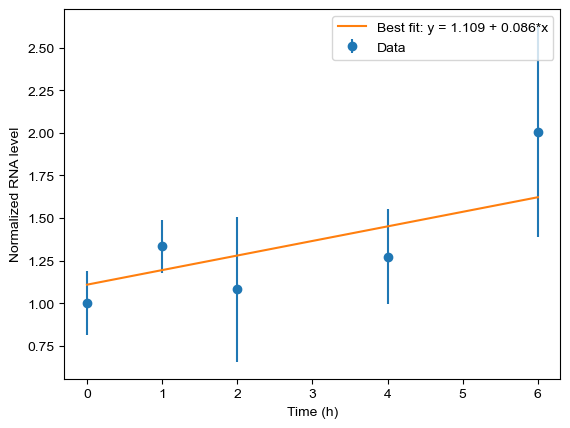

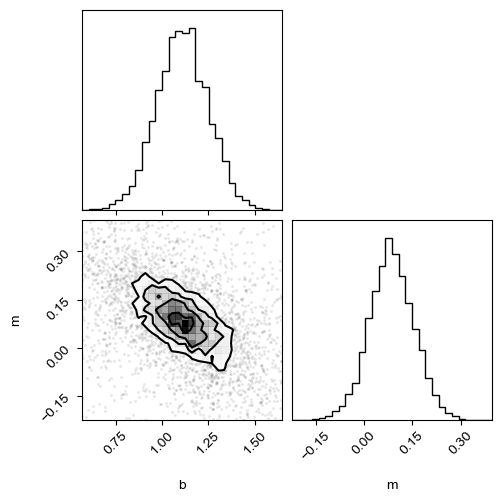

In [ ]:
# Define timepoints
timepoints = np.array([0, 1, 2, 4, 6])
# Extract NV_slow_data_points (rows 0 to 3)
NV_slow_data_points = NV_slow_data.iloc[0:4, 1:-1].values
T0_mean = np.mean(NV_slow_data_points[:, 0])
# Normalize the NV_slow_data_points by the mean of the T0 values
NV_slow_data_normalized = NV_slow_data_points / T0_mean

# Now get the mean and standard deviation of the normalized data
NV_slow_mean_normalized = np.mean(NV_slow_data_normalized, axis=0)
NV_slow_std_normalized = np.std(NV_slow_data_normalized, axis=0)

# Print the mean and standard deviation arrays
print("NV_slow_mean_normalized:", NV_slow_mean_normalized)
print("NV_slow_std_normalized:", NV_slow_std_normalized)

x = timepoints
y = NV_slow_mean_normalized
yerr = NV_slow_std_normalized

# Model 1
def model1(theta, t):
    return theta[0] + theta[1] * t # y = m*x + b + error




def model(theta, t):
    return model1(theta, t) 

# The likelihood function:
def loglike(theta):
    return -0.5*(np.sum((y-model(theta, x))**2/yerr**2))
# Defines a flat prior in -1 < m < 1, 0 < b < 10 (-1 < theta[1] < 1, 0 < theta[0] < 10):
def prior_transform(theta):
    return np.array([10., 2.]) * theta + np.array([0, -1])

# Run nested sampling
ndim = 2  # number of parameters
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=1000, callback=nestle.print_progress)
print(res.summary())
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("b = {0:5.6f} +/- {1:5.6f}".format(p[0], np.sqrt(cov[0, 0])))
print("m = {0:5.6f} +/- {1:5.6f}".format(p[1], np.sqrt(cov[1, 1])))
# Plot the best fit line
import matplotlib.pyplot as plt
plt.errorbar(x, y, yerr=yerr, fmt='o', label='Data')
plt.plot(x, model(p, x), label='Best fit: y = {0:.3f} + {1:.3f}*x'.format(p[0], p[1]))
plt.xlabel('Time (h)')
plt.ylabel('Normalized RNA level')
plt.legend()
plt.show()

#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['b', 'm'],
                    range=[0.9999, 0.99999], bins=30)  


# Define an exponential decay model with a half-life of 24 hours
def actual_decay_model(t):
    return  np.exp(-np.log(2)/24 * t) # y = A * exp(-ln(2)/t_half * t)

NV_correction_factors_normalized = model(p, timepoints)/actual_decay_model(timepoints)

### Now obtain the correction factor for the 2W cold samples

w2_slow_mean_normalized: [1.         0.85375992 0.77914185 1.0330343  0.85490426]
w2_slow_std_normalized: [0.07288434 0.16988127 0.23951518 0.11848704 0.2815707 ]
it= 84359 logz=-8.8572580800niter: 84360
ncall: 138327
nsamples: 94360
logz: -8.433 +/-  0.026
h:  6.575
b = 0.977508 +/- 0.068359
m = -0.002911 +/- 0.029762


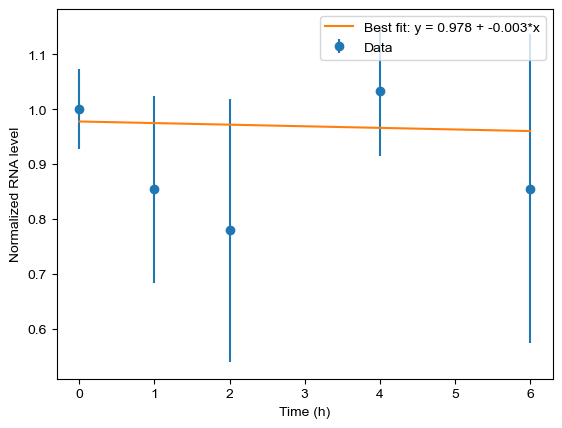

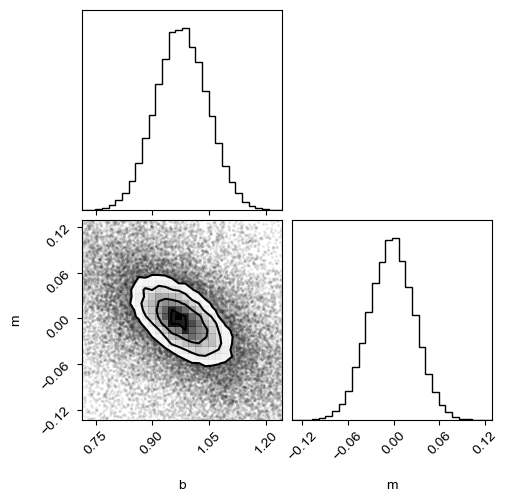

In [ ]:
# Define timepoints
timepoints = np.array([0, 1, 2, 4, 6])
# Extract w2_slow_data_points (rows 0 to 3)
w2_slow_data_points = W2_slow_data.iloc[0:4, 1:-1].values
T0_mean = np.mean(w2_slow_data_points[:, 0])
# Normalize the w2_slow_data_points by the mean of the T0 values
w2_slow_data_normalized = w2_slow_data_points / T0_mean
# Now get the mean and standard deviation of the normalized data
w2_slow_mean_normalized = np.mean(w2_slow_data_normalized, axis=0)
w2_slow_std_normalized = np.std(w2_slow_data_normalized, axis=0)

# Print the mean and standard deviation arrays
print("w2_slow_mean_normalized:", w2_slow_mean_normalized)
print("w2_slow_std_normalized:", w2_slow_std_normalized)

x = timepoints
y = w2_slow_mean_normalized
yerr = w2_slow_std_normalized

# Model 1
def model1(theta, t):
    return theta[0] + theta[1] * t # y = m*x + b + error



def model(theta, t):
    return model1(theta, t)

# The likelihood function:
def loglike(theta):
    return -0.5*(np.sum((y-model(theta, x))**2/yerr**2))    

# Defines a flat prior in -1 < m < 1, 0 < b < 10 (-1 < theta[1] < 1, 0 < theta[0] < 10):
def prior_transform(theta):
    return np.array([10., 2.]) * theta + np.array([0, -1])

# Run nested sampling
ndim = 2  # number of parameters
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("b = {0:5.6f} +/- {1:5.6f}".format(p[0], np.sqrt(cov[0, 0])))
print("m = {0:5.6f} +/- {1:5.6f}".format(p[1], np.sqrt(cov[1, 1])))
# Plot the best fit line
import matplotlib.pyplot as plt
plt.errorbar(x, y, yerr=yerr, fmt='o', label='Data')
plt.plot(x, model(p, x), label='Best fit: y = {0:.3f} + {1:.3f}*x'.format(p[0], p[1]))
plt.xlabel('Time (h)')
plt.ylabel('Normalized RNA level')
plt.legend()
plt.show()

#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['b', 'm'],
                    range=[0.9999, 0.99999], bins=30)

# Define an exponential decay model with a half-life of 24 hours (high confidence decay rate measured by Narsai et al., 2007)
# This decay rate is assumed unchanged after 2W cold treatment
def actual_decay_model(t):
    return  np.exp(-np.log(2)/24 * t) 

w2_correction_factors_normalized = model(p, timepoints)/actual_decay_model(timepoints)


## Fit an exponential decay to the non-vernalized *FLC* mRNA decay profile after normalization by the correction factors

### First extract and plot the data after applying the correction 

<ErrorbarContainer object of 3 artists>

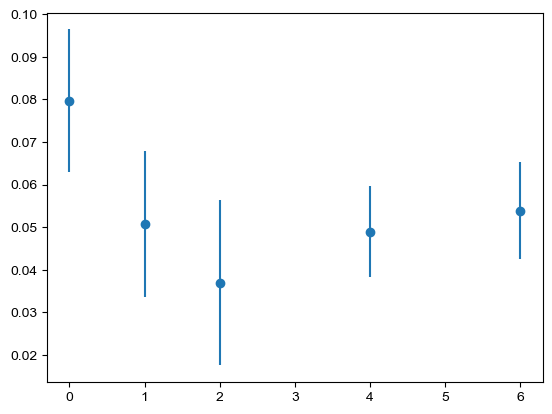

In [71]:
# Extract the NV_FLC_spliced data into an array
NV_FLC_spliced = NV_FLC_spliced_data.iloc[0:4, 1:-1].values
# Normalize this data using the NV correction factors
NV_FLC_spliced_normalized = NV_FLC_spliced / NV_correction_factors_normalized

# Compute average over rows
corrected_NV_FLC_spliced = np.mean(NV_FLC_spliced_normalized, axis=0)
corrected_NV_FLC_spliced_std = np.std(NV_FLC_spliced_normalized, axis=0)

# Now use these to plot the data with error bars
plt.errorbar(timepoints, corrected_NV_FLC_spliced, yerr=corrected_NV_FLC_spliced_std, fmt='o', label='NV_FLC_spliced')

### Specify the exponential decay model

In [72]:
# Fit an exponential decay model to the data
def model(theta, t):
    return theta[0] * np.exp(-theta[1] * t)

x = timepoints
y = corrected_NV_FLC_spliced
yerr = corrected_NV_FLC_spliced_std

# The likelihood function:
def loglike(theta):
    return -0.5 * np.sum((y - model(theta, x))**2 / yerr**2)

# Defines a flat prior in 0 < m < 1, 0 < b < 10:
def prior_transform(theta):
    return np.array([10., 1.]) * theta


### Infer decay parameters by nested sampling

In [73]:
# Perform nested sampling
ndim = 2  # number of parameters
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())

# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)

print("b = {0:5.6f} +/- {1:5.6f}".format(p[0], np.sqrt(cov[0, 0])))
print("m = {0:5.6f} +/- {1:5.6f}".format(p[1], np.sqrt(cov[1, 1])))

# Compute the half-life
half_life = np.log(2) / p[1]
half_life_error = half_life * np.sqrt(cov[1, 1]) / p[1]
print("Half-life = {0:5.6f} +/- {1:5.6f}".format(half_life, half_life_error))

it= 93042 logz=-10.26150924506niter: 93043
ncall: 169810
nsamples: 103043
logz: -9.827 +/-  0.027
h:  7.495
b = 0.066801 +/- 0.010871
m = 0.072078 +/- 0.046013
Half-life = 9.616628 +/- 6.138982


### Make a plot comparing the posterior mean to the data

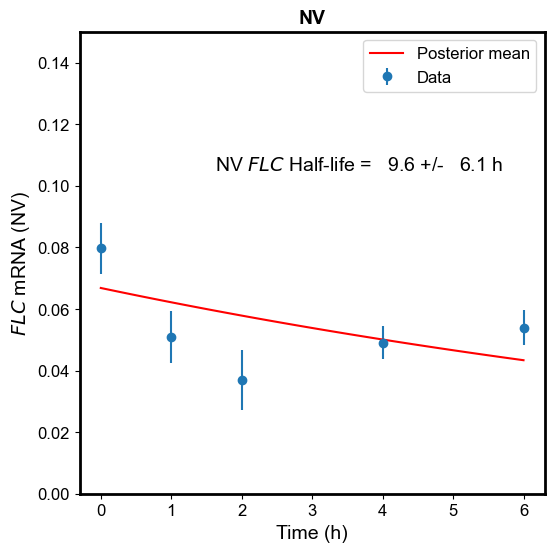

In [74]:
plot_times = np.linspace(0, 6, 100)
# Plot the results
plt.figure(figsize=(6, 6))
plt.errorbar(x, y, yerr=yerr/2, fmt='o', label='Data')
plt.plot(plot_times, model(p, plot_times), label='Posterior mean', color='red')
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('$\\it{FLC}$ mRNA (NV)', fontsize=14)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=12)
# Print the estimated half-life on the plot 
plt.text(0.6, 0.7, 'NV $FLC$ Half-life = {0:5.1f} +/- {1:5.1f} h'.format(half_life, half_life_error),
         transform=plt.gca().transAxes, fontsize=14, ha='center')

# Insert title in bold
plt.title('NV', fontsize=14, fontweight='bold')
# Set ylim
plt.ylim(0, 0.15)
# Show legend with font size of 12 
plt.legend(fontsize=12)

# Increase box thickness
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Save the figure
plt.savefig('NV_FLC_decay.pdf')
plt.show()

### Plot the posterior distribution of the inferred parameters

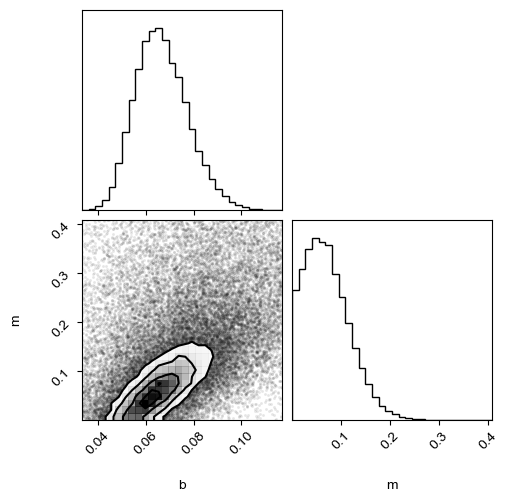

In [18]:
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['b', 'm'],
                    range=[0.9999, 0.99999], bins=30)

## Fit an exponential decay to the 2W cold treated *FLC* mRNA decay profile after normalization by the correction factors

### First extract and plot the data after applying the correction 

<ErrorbarContainer object of 3 artists>

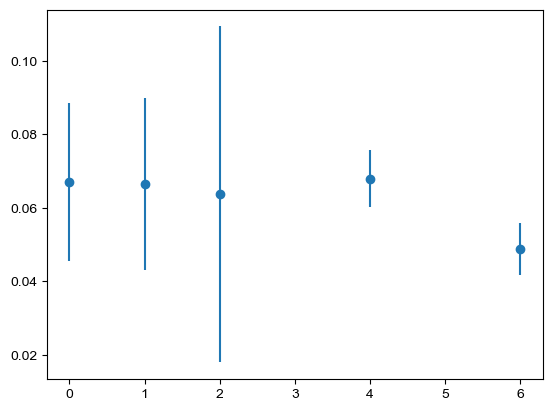

In [75]:
# Extract the W2_FLC_spliced data into an array
W2_FLC_spliced = W2_FLC_spliced_data.iloc[0:4, 1:-1].values
# Normalize this data using the W2 correction factors
W2_FLC_spliced_normalized = W2_FLC_spliced / w2_correction_factors_normalized

# Compute average over rows
corrected_W2_FLC_spliced = np.mean(W2_FLC_spliced_normalized, axis=0)
corrected_W2_FLC_spliced_std = np.std(W2_FLC_spliced_normalized, axis=0)

# Now use these to plot the data with error bars
plt.errorbar(timepoints, corrected_W2_FLC_spliced, yerr=corrected_W2_FLC_spliced_std, fmt='o', label='W2_FLC_spliced')




In [76]:
# Print the W2_FLC_spliced dataframe
print("W2_FLC_spliced dataframe:")
print(W2_FLC_spliced_data)

W2_FLC_spliced dataframe:
  FLC spliced        0h        1h        2h        4h        6h    6hDMSO
0          R1  0.059881  0.084880  0.141437  0.088077  0.057841  0.064774
1          R2  0.071211  0.027046  0.012794  0.067995  0.059881  0.076675
2          R3  0.094835  0.083133  0.059605  0.069263  0.063149  0.071046
3          R4  0.036606  0.072205  0.048526  0.069745  0.042244  0.033068
4          Av  0.065633  0.066816  0.040308  0.073770  0.055779  0.061391
5       Stdev  0.024218  0.027100  0.024464  0.009566  0.009284  0.019498


### Specify the exponential decay model

In [ ]:
# Fit an exponential decay model to the w2 data
def model(theta, t):
    return theta[0] * np.exp(-theta[1] * t) # y = b * exp(-m*t)

x = timepoints
y = corrected_W2_FLC_spliced
yerr = corrected_W2_FLC_spliced_std

# The likelihood function:
def loglike(theta):
    return -0.5 * np.sum((y - model(theta, x))**2 / yerr**2)

# Defines a flat prior in 0 < m < 1, 0 < b < 10 (0 < theta[0] < 10, 0 < theta[1] < 1):
def prior_transform(theta):
    return np.array([10., 1.]) * theta


### Infer parameters by nested sampling

In [78]:
# Perform nested sampling
ndim = 2  # number of parameters
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())

# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)

print("b = {0:5.6f} +/- {1:5.6f}".format(p[0], np.sqrt(cov[0, 0])))
print("m = {0:5.6f} +/- {1:5.6f}".format(p[1], np.sqrt(cov[1, 1])))

# Compute the half-life
half_life = np.log(2) / p[1]
half_life_error = half_life * np.sqrt(cov[1, 1]) / p[1]
print("Half-life = {0:5.6f} +/- {1:5.6f}".format(half_life, half_life_error))

it= 96984 logz=-10.12361675717niter: 96985
ncall: 172687
nsamples: 106985
logz: -9.695 +/-  0.028
h:  7.916
b = 0.080699 +/- 0.013532
m = 0.070763 +/- 0.035812
Half-life = 9.795336 +/- 4.957289


### Plot the decay curve for the posterior mean a compare with data

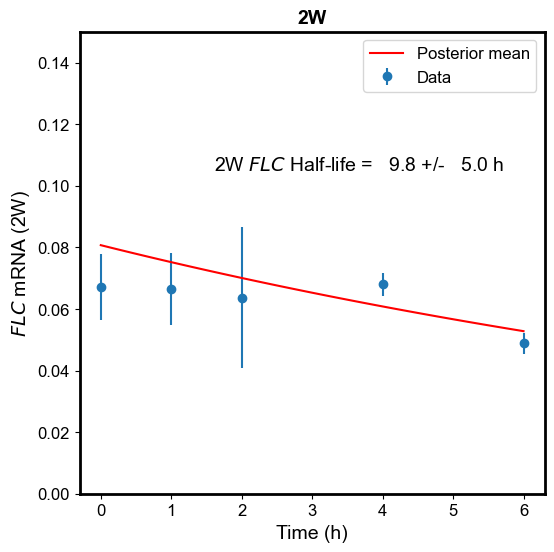

In [79]:
plot_times = np.linspace(0, 6, 100)
# Plot the results
plt.figure(figsize=(6, 6))
plt.errorbar(x, y, yerr=yerr/2, fmt='o', label='Data')
plt.plot(plot_times, model(p, plot_times), label='Posterior mean', color='red')
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('$\\it{FLC}$ mRNA (2W)', fontsize=14)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=12)
# Print the estimated half-life on the plot 
plt.text(0.6, 0.7, '2W $FLC$ Half-life = {0:5.1f} +/- {1:5.1f} h'.format(half_life, half_life_error),
         transform=plt.gca().transAxes, fontsize=14, ha='center')

# Insert title in bold
plt.title('2W', fontsize=14, fontweight='bold')
# Set ylim
plt.ylim(0, 0.15)
# Show legend with font size of 12 
plt.legend(fontsize=12)

# Increase box thickness
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Save the figure
plt.savefig('2W_FLC_decay.pdf')
plt.show()

### Plot the posterior distribution of the parameters

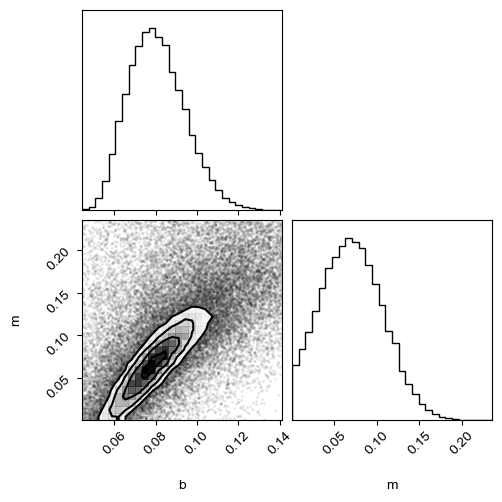

In [24]:
#%% Plot the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['b', 'm'],
                    range=[0.9999, 0.99999], bins=30)

### First extract and plot the data after applying the correction 

<ErrorbarContainer object of 3 artists>

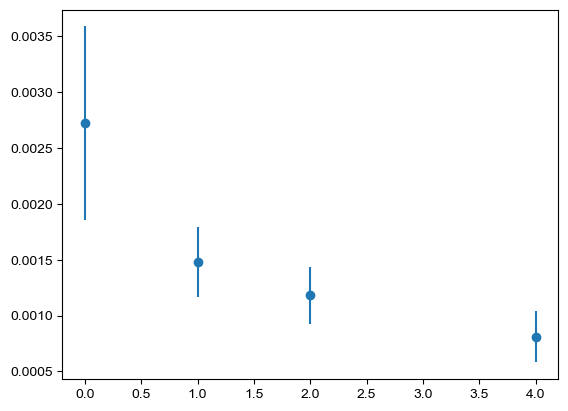

In [63]:
# Extract the NV_fast data into an array (AT2G37650 )
NV_fast = NV_fast_data.iloc[0:4, 1:-2].values
# Normalize this data using NV correction factors
NV_fast_normalized = NV_fast / NV_correction_factors_normalized[:-1]

# Compute the average and sd over rows
corrected_NV_fast_average = NV_fast_normalized.mean(axis=0)
corrected_NV_fast_sd = NV_fast_normalized.std(axis=0)

# Drop the last two timepoints
fast_timepoints = timepoints[:-1]
# Now use these to plot the data with errorbars
plt.errorbar(fast_timepoints, corrected_NV_fast_average, yerr=corrected_NV_fast_sd, fmt='o', label='NV_fast')

### Specify the exponential decay model

In [ ]:
# Fit an exponential decay model to the data
def model(theta, t):
    return theta[0] * np.exp(-theta[1] * t) # y = b * exp(-m*t)

x = fast_timepoints
y = corrected_NV_fast_average
yerr = corrected_NV_fast_sd

# The likelihood function:
def loglike(theta):
    return -0.5 * np.sum((y - model(theta, x))**2 / yerr**2)

# Defines a flat prior in 0 < b < 1, 0 < m < 1 (0 < theta[0] < 1, 0 < theta[1] < 1):
def prior_transform(theta):
    return np.array([1.,1.]) * theta

### Infer parameters by nested sampling

In [65]:
# Perform nested sampling
ndim = 2  # number of parameters
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())

# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)

print("b = {0:5.6f} +/- {1:5.6f}".format(p[0], np.sqrt(cov[0, 0])))
print("m = {0:5.6f} +/- {1:5.6f}".format(p[1], np.sqrt(cov[1, 1])))


# Compute the half-life
half_life = np.log(2) / p[1]
half_life_error = half_life * np.sqrt(cov[1, 1]) / p[1]
print("Half-life = {0:5.6f} +/- {1:5.6f}".format(half_life, half_life_error))

it= 93888 logz=-9.3861565855705niter: 93889
ncall: 168200
nsamples: 103889
logz: -8.966 +/-  0.027
h:  7.466
b = 0.002212 +/- 0.000513
m = 0.302811 +/- 0.127085
Half-life = 2.289041 +/- 0.960673


### Plot the decay curve for the posterior mean a compare with data

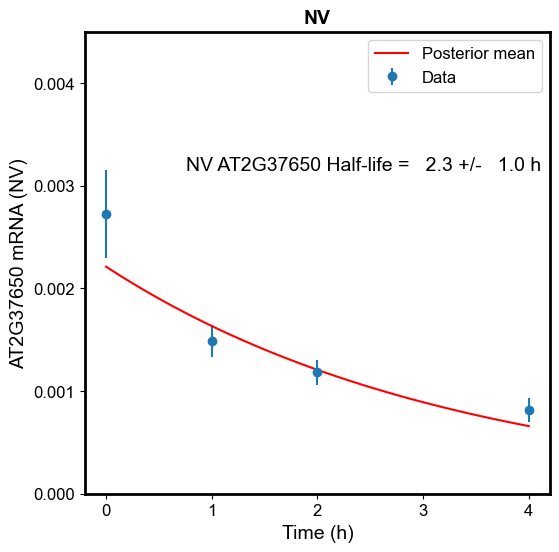

In [66]:
plot_times = np.linspace(0, 4, 100)

# Plot the results
plt.figure(figsize=(6, 6))
plt.errorbar(x, y, yerr=yerr/2, fmt='o', label='Data')
plt.plot(plot_times, model(p, plot_times), label='Posterior mean', color='red')
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('AT2G37650 mRNA (NV)', fontsize=14)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=12)
# Print the estimated half-life on the plot
plt.text(0.6, 0.7, 'NV AT2G37650 Half-life = {0:5.1f} +/- {1:5.1f} h'.format(half_life, half_life_error),
         transform=plt.gca().transAxes, fontsize=14, ha='center')

# Insert title in bold
plt.title('NV', fontsize=14, fontweight='bold')
# Set ylim
plt.ylim(0, 0.0045)
# Show legend with font size of 12 
plt.legend(fontsize=12)

# Increase box thickness
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
# Specify y-ticks
plt.yticks(np.arange(0, 0.0045, 0.001))
# Specify x-ticks
plt.xticks(np.arange(0, 4.5, 1))
# Save as pdf
plt.savefig('NV_AT2G37650_decay.pdf')
plt.show()

### First extract and plot the data after applying the correction 

<ErrorbarContainer object of 3 artists>

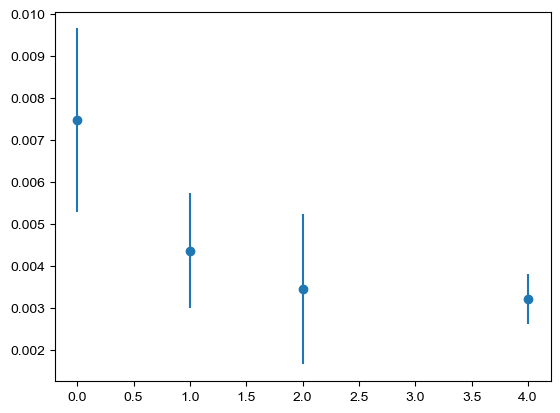

In [67]:
# Extract the W2 fast data into an array
W2_fast = W2_fast_data.iloc[0:4, 1:-2].values
# Normalize this data using W2 correction factors
W2_fast_normalized = W2_fast / w2_correction_factors_normalized[:-1]

# Compute the average and sd over rows
corrected_W2_fast_average = W2_fast_normalized.mean(axis=0)
corrected_W2_fast_sd = W2_fast_normalized.std(axis=0)

# Now use these to plot the data with errorbars
plt.errorbar(fast_timepoints, corrected_W2_fast_average, yerr=corrected_W2_fast_sd, fmt='o', label='W2_fast')


### Specify the exponential decay model

In [ ]:
# Fit an exponential decay model to the data
def model(theta, t):
    return theta[0] * np.exp(-theta[1] * t) # y = b * exp(-m*t)

x = fast_timepoints
y = corrected_W2_fast_average
yerr = corrected_W2_fast_sd

# The likelihood function:
def loglike(theta):
    return -0.5 * np.sum((y - model(theta, x))**2 / yerr**2)

# Defines a flat prior in 0 < m < 1, 0 < b < 1 (0 < theta[0] < 1, 0 < theta[1] < 1):
def prior_transform(theta):
    return np.array([1., 1.]) * theta

### Infer parameters by nested sampling

In [69]:
# Perform nested sampling
ndim = 2  # number of parameters
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())

# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)

print("b = {0:5.6f} +/- {1:5.6f}".format(p[0], np.sqrt(cov[0, 0])))
print("m = {0:5.6f} +/- {1:5.6f}".format(p[1], np.sqrt(cov[1, 1])))

# Compute the half-life
half_life = np.log(2) / p[1]
half_life_error = half_life * np.sqrt(cov[1, 1]) / p[1]
print("Half-life = {0:5.6f} +/- {1:5.6f}".format(half_life, half_life_error))

it= 85374 logz=-8.604164809147niter: 85375
ncall: 154700
nsamples: 95375
logz: -8.182 +/-  0.026
h:  6.683
b = 0.006204 +/- 0.001454
m = 0.185396 +/- 0.086920
Half-life = 3.738730 +/- 1.752840


### Plot the decay curve for the posterior mean a compare with data

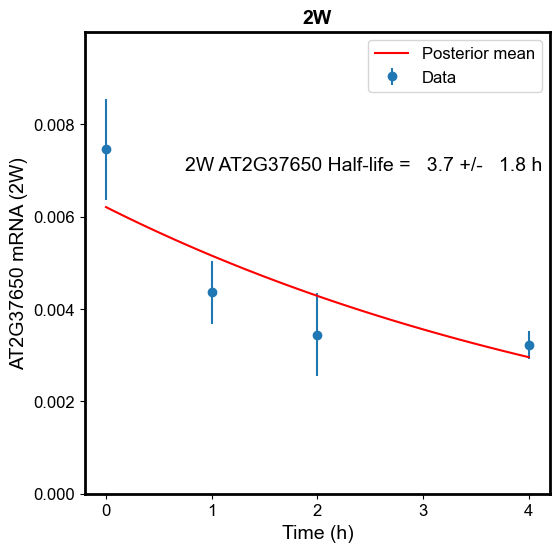

In [70]:
plot_times = np.linspace(0, 4, 100)

# Plot the results
plt.figure(figsize=(6, 6))
plt.errorbar(x, y, yerr=yerr/2, fmt='o', label='Data')
plt.plot(plot_times, model(p, plot_times), label='Posterior mean', color='red')
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('AT2G37650 mRNA (2W)', fontsize=14)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=12)
# Print the estimated half-life on the plot
plt.text(0.6, 0.7, '2W AT2G37650 Half-life = {0:5.1f} +/- {1:5.1f} h'.format(half_life, half_life_error),
         transform=plt.gca().transAxes, fontsize=14, ha='center')

# Insert title in bold
plt.title('2W', fontsize=14, fontweight='bold')
# Set ylim
plt.ylim(0, 0.01)
# Show legend with font size of 12 
plt.legend(fontsize=12)

# Increase box thickness
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
# Specify y-ticks
plt.yticks(np.arange(0, 0.01, 0.002))
# Specify x-ticks
plt.xticks(np.arange(0, 4.5, 1))
# Save as pdf
plt.savefig('2W_AT2G37650_decay.pdf')
plt.show()

## Estimate decay rate of PP2A NV

### First extract and plot the data after applying the correction 

<ErrorbarContainer object of 3 artists>

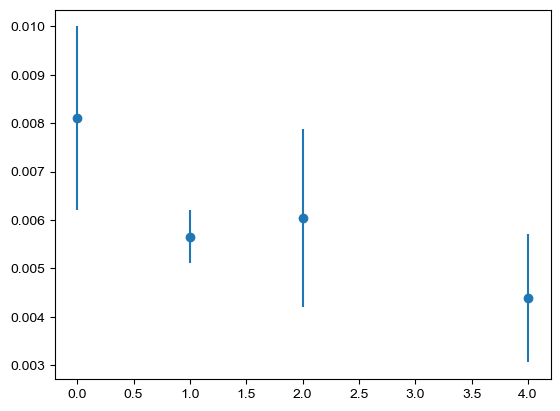

In [13]:
fast_timepoints = timepoints[:-1]
# Extract the NV_PP2A data into an array
NV_PP2A = NV_PP2A_data.iloc[0:4, 1:-2].dropna().values
# Normalize this data using NV correction factors
NV_PP2A_normalized = NV_PP2A / NV_correction_factors_normalized[:-1]
# Compute the average and sd over rows
corrected_NV_PP2A_average = NV_PP2A_normalized.mean(axis=0)
corrected_NV_PP2A_sd = NV_PP2A_normalized.std(axis=0)
# Now use these to plot the data with errorbars
plt.errorbar(fast_timepoints, corrected_NV_PP2A_average, yerr=corrected_NV_PP2A_sd, fmt='o', label='NV_PP2A')

### Specify the exponential decay model and infer parameters by nested sampling

In [ ]:
# Fit an exponential decay model to the data
def model(theta, t):
    return theta[0] * np.exp(-theta[1] * t) # y = b * exp(-m*t)

x = fast_timepoints
y = corrected_NV_PP2A_average
yerr = corrected_NV_PP2A_sd

# The likelihood function:
def loglike(theta):
    return -0.5 * np.sum((y - model(theta, x))**2 / yerr**2)

# Defines a flat prior in 0 < b < 1, 0 < m < 1 (0 < theta[0] < 1, 0 < theta[1] < 1) :
def prior_transform(theta):
    return np.array([1.,1.]) * theta

# Perform nested sampling
ndim = 2  # number of parameters
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())    

# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)  
print("b = {0:5.6f} +/- {1:5.6f}".format(p[0], np.sqrt(cov[0, 0])))
print("m = {0:5.6f} +/- {1:5.6f}".format(p[1], np.sqrt(cov[1, 1])))

# Compute the half-life
half_life = np.log(2) / p[1]
half_life_error = half_life * np.sqrt(cov[1, 1]) / p[1]
print("Half-life = {0:5.6f} +/- {1:5.6f}".format(half_life, half_life_error))





it= 87593 logz=-8.829029876207niter: 87594
ncall: 153360
nsamples: 97594
logz: -8.407 +/-  0.026
h:  6.867
b = 0.007079 +/- 0.001048
m = 0.178751 +/- 0.113724
Half-life = 3.877727 +/- 2.467070


### Plot the decay curve for the posterior mean a compare with data

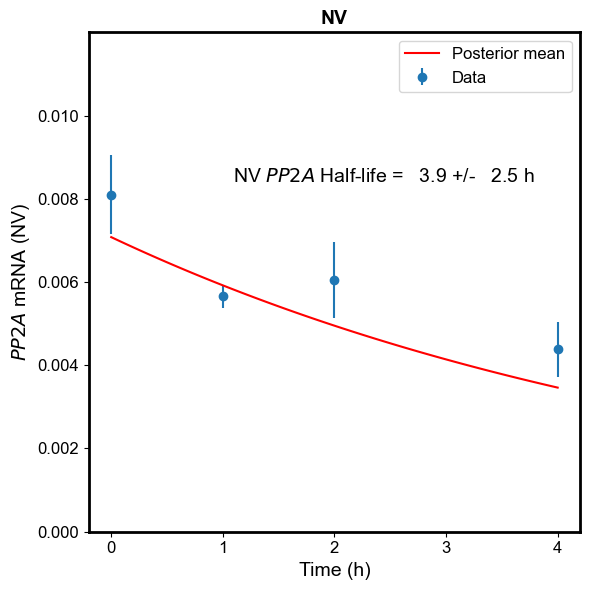

In [15]:
plot_times = np.linspace(0, 4, 100)

# Plot the results
plt.figure(figsize=(6, 6))
plt.errorbar(x, y, yerr=yerr/2, fmt='o', label='Data')
plt.plot(plot_times, model(p, plot_times), label='Posterior mean', color='red')
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('$PP2A$ mRNA (NV)', fontsize=14)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=12)
# Print the estimated half-life on the plot
plt.text(0.6, 0.7, 'NV $PP2A$ Half-life = {0:5.1f} +/- {1:5.1f} h'.format(half_life, half_life_error),
         transform=plt.gca().transAxes, fontsize=14, ha='center')

# Insert title in bold
plt.title('NV', fontsize=14, fontweight='bold')
# Set ylim
plt.ylim(0, 0.012)
# Show legend with font size of 12 
plt.legend(fontsize=12)

# Increase box thickness
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
# Specify y-ticks
plt.yticks(np.arange(0, 0.012, 0.002))
# Specify x-ticks
plt.xticks(np.arange(0, 4.5, 1))

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save as pdf
plt.savefig('NV_PP2A_decay.pdf', bbox_inches='tight')
plt.show()

### Plot the estimated posterior distribution

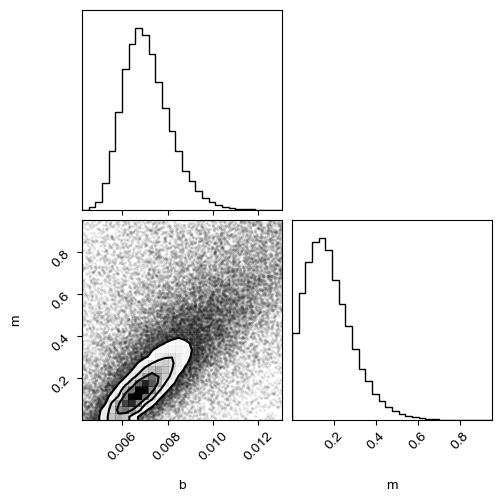

In [52]:
# Show the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['b', 'm'],
                    range=[0.9999, 0.99999], bins=30)

## Estimate decay rate of PP2A at 2W

### First extract and plot the data after applying the correction 

<ErrorbarContainer object of 3 artists>

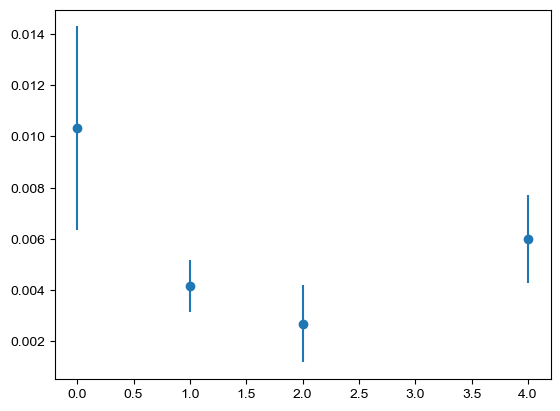

In [16]:
fast_timepoints = timepoints[:-1]
# Extract the W2_PP2A data into an array
W2_PP2A = W2_PP2A_data.iloc[0:4, 1:-2].dropna().values
# Normalize this data using W2 correction factors
W2_PP2A_normalized = W2_PP2A / w2_correction_factors_normalized[:-1]
# Compute the average and sd over rows
corrected_W2_PP2A_average = W2_PP2A_normalized.mean(axis=0)
corrected_W2_PP2A_sd = W2_PP2A_normalized.std(axis=0)
# Now use these to plot the data with errorbars
plt.errorbar(fast_timepoints, corrected_W2_PP2A_average, yerr=corrected_W2_PP2A_sd, fmt='o', label='W2_PP2A')


### Specify the exponential decay model, infer parameters by nested sampling, and plot the estimated posterior distribution of parameters

it= 82476 logz=-10.0351992132niter: 82477
ncall: 152708
nsamples: 92477
logz: -9.683 +/-  0.024
h:  5.778
b = 0.006307 +/- 0.002090
m = 0.276429 +/- 0.244501
Half-life = 2.507503 +/- 2.217877


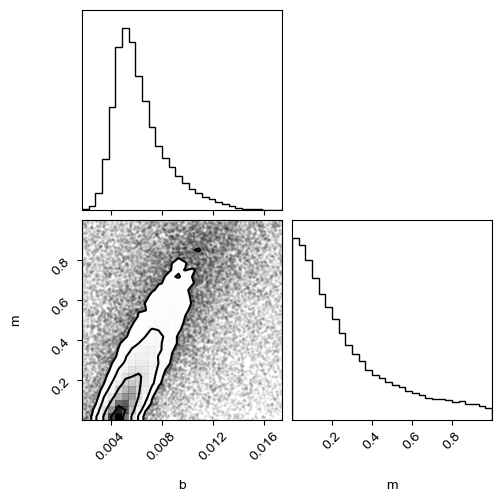

In [ ]:
# Fit an exponential decay model to the data
def model(theta, t):
    return theta[0] * np.exp(-theta[1] * t) # y = b * exp(-m*t)
x = fast_timepoints
y = corrected_W2_PP2A_average
yerr = corrected_W2_PP2A_sd
# The likelihood function:
def loglike(theta):
    return -0.5 * np.sum((y - model(theta, x))**2 / yerr**2)

# Defines a flat prior in 0 < b < 1, 0 < m < 1 (0 < theta[0] < 1, 0 < theta[1] < 1):
def prior_transform(theta):
    return np.array([1.,1.]) * theta
# Perform nested sampling
ndim = 2  # number of parameters
res = nestle.sample(loglike, prior_transform, ndim, method='single',
                    npoints=10000, callback=nestle.print_progress)
print(res.summary())
# weighted average and covariance:
p, cov = nestle.mean_and_cov(res.samples, res.weights)
print("b = {0:5.6f} +/- {1:5.6f}".format(p[0], np.sqrt(cov[0, 0])))
print("m = {0:5.6f} +/- {1:5.6f}".format(p[1], np.sqrt(cov[1, 1])))
# Compute the half-life
half_life = np.log(2) / p[1]
half_life_error = half_life * np.sqrt(cov[1, 1]) / p[1]
print("Half-life = {0:5.6f} +/- {1:5.6f}".format(half_life, half_life_error))


# Show the corner plot for the parameters
fig = corner.corner(res.samples, weights=res.weights, labels=['b', 'm'],
                    range=[0.9999, 0.99999], bins=30)

### Plot the decay curve for the posterior mean and compare to data

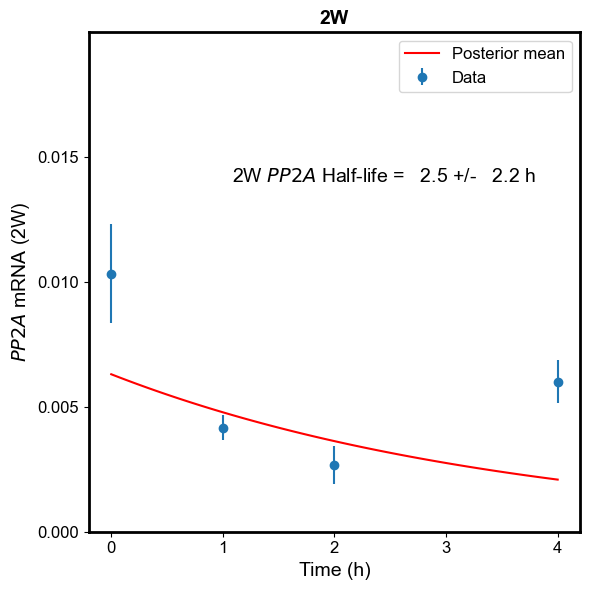

In [ ]:
plot_times = np.linspace(0, 4, 100)

# Plot the results
plt.figure(figsize=(6, 6))
plt.errorbar(x, y, yerr=yerr/2, fmt='o', label='Data')
plt.plot(plot_times, model(p, plot_times), label='Posterior mean', color='red')
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('$PP2A$ mRNA (2W)', fontsize=14)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=12)
# Print the estimated half-life on the plot
plt.text(0.6, 0.7, '2W $PP2A$ Half-life = {0:5.1f} +/- {1:5.1f} h'.format(half_life, half_life_error),
         transform=plt.gca().transAxes, fontsize=14, ha='center')

# Insert title in bold
plt.title('2W', fontsize=14, fontweight='bold')
# Set ylim
plt.ylim(0, 0.02)
# Show legend with font size of 12 
plt.legend(fontsize=12)

# Increase box thickness
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
# Specify y-ticks
plt.yticks(np.arange(0, 0.02, 0.005))
# Specify x-ticks
plt.xticks(np.arange(0, 4.5, 1))
# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save as pdf
plt.savefig('2W_PP2A_decay.pdf', bbox_inches='tight')
plt.show()

